In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import scipy as sp
from scipy.io import mmread
import networkx as nx
from collections import defaultdict
from matplotlib import pyplot as plt

In [ ]:
def csr_info(mat, name="", non_empy=False):
    r""" Print out info about this CSR matrix. If non_empy, 
    report number of non-empty rows and cols as well
    """
    if non_empy:
        print("%s [nrows %d (%d non-empty), ncols %d (%d non-empty), nnz %d]" % (
                name, mat.shape[0], 
                sum(1 if mat.indptr[i+1] > mat.indptr[i] else 0 
                for i in range(mat.shape[0])), 
                mat.shape[1], len(np.unique(mat.indices)), 
                len(mat.data)))
    else:
        print( "%s [nrows %d, ncols %d, nnz %d]" % (name, 
                mat.shape[0], mat.shape[1], len(mat.data)) )

def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat

def csr_idf(matrix, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        matrix = matrix.copy()
    nrows = matrix.shape[0]
    nnz = matrix.nnz
    ind, val, ptr = matrix.indices, matrix.data, matrix.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  ## df turns to idf - reusing memory
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else matrix

In [ ]:
def runKMeans(mat, n_clusters, method = 'mini-batch'):
  """
  runs KMeans or Mini-Batch KMeans on a given matrix for a given number of clusters
  returns the predictions, the centroids of the clusters, and the model itself
  method - default is mini-batch, can also do full KMeans by entering 'full'
  """
  km = None
  if method == 'mini-batch':
    km = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
  elif method == 'full':
    km = KMeans(n_clusters=n_clusters, random_state=0)
  else:
    print("INVALID METHOD")
    exit()
  km.fit(mat)
  preds = km.predict(mat)
  centroids = km.cluster_centers_
  return preds, centroids, km

In [ ]:
def findEpsNeighbors(p, centroids, eps, metric = 'euclidean'):
  """
  finds which points(centroids) are epsilon neighbors to p
  metric - can be euclidean (default) or cosine
  """
  point = centroids[p]
  neighbors = []
  for i in range (len(centroids)):
    if i == p:
      continue
    else:
      distance = None
      if (metric == 'euclidean'):
        distance = euclidean(point, centroids[i])
      elif (metric == 'cosine'):
        distance = cosine(point, centroids[i])
      else:
        print("INVALID METRIC")
        exit()
      if distance <= eps:
        neighbors.append(i)
  return neighbors

In [ ]:
def assignBorderPoints(border_points, centroids, centers, clusters, metric = 'euclidean'):
  """
  given a set of border_points, assign them to the closest centroid
  return the modified clusters with border points added to them
  """
  for bp in border_points:
    distances = []
    if metric == 'euclidean':
        for c in centers:
          distances.append(euclidean(centroids[bp], c))
    elif metric == 'cosine':
        for c in centers:
          distances.append(cosine(centroids[bp], c))
    else:
      print("INVALID METRIC")
      exit()
    index = distances.index(min(distances))
    #print(index)
    clusters[index].add(bp)
  return clusters

In [ ]:
def findConnectedCores(core_points, eps, metric = 'euclidean'):
  """
  builds a graph of core points and connects the verticies that are within eps of eachother
  takes the list of all the connected components, and returns them as clusters
  """
  G = nx.Graph()
  G.add_nodes_from(core_points)
  for i in range(len(core_points)):
    for j in range(len(core_points)):
      distance = None
      if (metric == 'euclidean'):
        distance = euclidean(centroids[core_points[i]], centroids[core_points[j]])
      elif (metric == 'cosine'):
        distance = cosine(centroids[core_points[i]], centroids[core_points[j]])
      else:
        print("INVALID METRIC")
        exit()
      if ((i != j) and distance <= eps):
        G.add_edges_from([(core_points[i], core_points[j])])
  clusters = list(nx.connected_components(G))
  return clusters

In [ ]:
def assignFinalClusters(clusters, predictions):
  """
  Will go through and assign final clusters based upon the clustered centroids
  """
  new_predictions = []
  for p in predictions:
    for i in range(0, len(clusters)):
      if p in clusters[i]:
        new_predictions.append(i)
        break
      if i == len(clusters) -1:
        print(p)
  return new_predictions

In [ ]:
def DBScan(centroids, eps, minpts, metric = 'euclidean'):
  """
  centroids - centroids generated by kmeans
  eps - epsilon radius for neighbor evaluation
  minpts - minimum number of points to be considered a core point
  metric - distance metric, can be euclidean(default) or cosine
  """
  core_points = []
  border_points = []
  noise_points = []
  clusters = []
  #saves what points we've vistited
  visited = []
  #list of neighbor lists
  neighbors = []
  #  ---  first, establish core, border, and noise points...
  for i in range (len(centroids)):
    eps_neighbors=[]
    if i not in visited:
      visited.append(i)
      eps_neighbors = findEpsNeighbors(i, centroids, eps, metric=metric)
      #if no neighbors, its a noise point
      if (len(eps_neighbors) == 0):
        noise_points.append(i)
      #if more than minpts, then core point
      elif (len(eps_neighbors) >= minpts):
        core_points.append(i)
        neighbors.append(eps_neighbors)
      #if in between, its a border point
      else:
        border_points.append(i)
  #verify we have classified all points
  print('Core: ' + str(len(core_points)))
  print('Border: ' + str(len(border_points)))
  print('Noise: ' + str(len(noise_points)))
  print('Total Classified: ' + str(len(core_points) + len((border_points)) + len(noise_points)))
  # --- now, time to do some fancy graph stuff to find which core_points are connected
  #populate graph with core_points being nodes
  clusters = findConnectedCores(core_points, eps, metric=metric)
  #now we have determiend the connected components in our generated graph!
  print(len(clusters))
  print(clusters)
  #lets assign each cluster a centroid
  centers = []
  for c in clusters:
    data_points = []
    #find all data points in cluster
    for index in list(c):
      data_points.append(centroids[index])
    #append the mean of all data points
    centers.append(np.mean(data_points, axis=0))
  print('Centroids generated, assigning border points')
  #now we need to look through the border points and see which clusters they belong 
  #to based on which centroid they are closest to (using selected metric)
  clusters = assignBorderPoints(border_points, centroids, centers, clusters, metric=metric)
  clusters.append(set(noise_points))
  print(len(clusters))
  print(clusters)
  print(border_points)
  return clusters

In [ ]:
def runTSVD(data, n_comp):
  tsvd = TruncatedSVD(n_components=n_comp)
  return tsvd.fit_transform(data)

In [ ]:
with open('train.dat', 'r') as f:
  lines = f.readlines()

data = [l.split() for l in lines]
dicts = []
cols = set()
for i in range(len(data)):
  dic = {}
  for j in range(0, len(data[i]), 2):
    dic[int(data[i][j])] = int(data[i][j+1]) 
    cols.add(int(data[i][j]))
  dicts.append(dic)
  
M = len(dicts)
N = len(cols)
cols = list(cols)

In [ ]:
print(len(lines))

8580


In [ ]:
values = []
columns = []
rows = []
for i in range (len(dicts)):
  d = dicts[i]
  for k in d.keys():
    columns.append(k)
    values.append(d[k])
    rows.append(i)

In [ ]:
#mat = sp.sparse.csr_matrix((values, (rows, columns)), dtype=np.float64)
#csr_idf(mat)

norm_mat = sp.sparse.csr_matrix((values, (rows, columns)), dtype=np.float64)
csr_idf(norm_mat)
csr_l2normalize(norm_mat)

In [ ]:
#running truncated single value decomposition to cut number of features roughly in half
#tsvd_norm_mat = runTSVD(norm_mat, 1500)

In [ ]:
preds, centroids, km = runKMeans(norm_mat, 300, method='full')
#preds, centroids, km = runKMeans(norm_mat, 100)

In [ ]:

#clus_euc = DBScan(centroids, 0.45, 2, metric = 'euclidean')
clus_cos = DBScan(centroids, 0.61, 5, metric = 'cosine')

Core: 28
Border: 53
Noise: 19
Total Classified: 100
3
[{2, 3, 7, 10, 17, 31, 33, 36, 46, 50, 59, 60, 63, 64, 66, 67, 70, 91, 94, 95, 97, 98, 99}, {18, 44, 5, 52}, {6}]
Centroids generated, assigning border points
4
[{1, 2, 3, 4, 7, 9, 10, 11, 14, 15, 16, 17, 20, 22, 24, 26, 27, 29, 30, 31, 32, 33, 36, 38, 39, 42, 46, 47, 48, 49, 50, 51, 53, 55, 59, 60, 61, 63, 64, 66, 67, 68, 69, 70, 73, 75, 76, 79, 82, 83, 84, 85, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}, {65, 35, 5, 8, 44, 18, 52, 56, 88}, {0, 37, 6, 72, 12, 78, 80, 57}, {34, 71, 40, 41, 74, 43, 13, 45, 77, 81, 19, 21, 54, 23, 86, 25, 58, 28, 62}]
[0, 1, 4, 8, 9, 11, 12, 14, 15, 16, 20, 22, 24, 26, 27, 29, 30, 32, 35, 37, 38, 39, 42, 47, 48, 49, 51, 53, 55, 56, 57, 61, 65, 68, 69, 72, 73, 75, 76, 78, 79, 80, 82, 83, 84, 85, 87, 88, 89, 90, 92, 93, 96]


In [ ]:
silhouette_score(norm_mat, assignFinalClusters(clus_cos, preds))

0.009181035735019504

In [ ]:
scores = []
mp = []
for i in range (3, 23, 2):
  res = DBScan(centroids, 0.65, i, metric = 'cosine')
  p = assignFinalClusters(res, preds)
  scores.append(silhouette_score(norm_mat, p))
  mp.append(i)
scores

Core: 185
Border: 62
Noise: 53
Total Classified: 300
5
[{0, 1, 2, 4, 5, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 21, 22, 25, 27, 28, 29, 31, 33, 36, 37, 39, 40, 43, 45, 46, 47, 51, 52, 53, 54, 56, 57, 59, 61, 62, 69, 70, 71, 72, 74, 75, 76, 77, 80, 88, 90, 91, 94, 95, 98, 100, 104, 105, 106, 107, 108, 112, 117, 119, 120, 123, 124, 128, 131, 132, 133, 135, 139, 141, 146, 148, 149, 152, 163, 164, 167, 168, 170, 171, 173, 174, 175, 176, 177, 180, 181, 182, 185, 192, 193, 194, 197, 200, 201, 202, 206, 208, 210, 213, 216, 218, 223, 224, 229, 237, 240, 241, 244, 245, 246, 247, 249, 251, 252, 253, 256, 257, 258, 260, 262, 264, 265, 268, 271, 273, 275, 277, 278, 279, 282, 283, 286, 292, 294, 297, 298, 299}, {3, 142, 14, 144, 270, 281, 26, 287, 162, 34, 35, 44, 49, 179, 186, 187, 67, 203, 211, 228, 101, 235, 109}, {161, 290, 261, 11, 81, 85, 151, 280, 127}, {16}, {32, 263, 78, 207, 147, 150, 23, 118, 219, 190}]
Centroids generated, assigning border points
6
[{0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 

[0.006301458355133793,
 0.006232471360018879,
 0.008574254614219868,
 0.008455150270652554,
 0.009356315975071068,
 0.007041811458063236,
 0.007128793221116364,
 0.004624286868803471,
 0.005897884027573205,
 0.005863094874132665]

In [ ]:
DBScan(centroids, 0.65, 6, metric='cosine')

Core: 122
Border: 125
Noise: 53
Total Classified: 300
5
[{0, 1, 2, 5, 7, 8, 9, 12, 13, 15, 18, 21, 29, 31, 33, 36, 37, 39, 40, 43, 45, 47, 51, 52, 56, 57, 59, 61, 62, 69, 70, 71, 72, 75, 80, 88, 90, 91, 98, 104, 107, 117, 124, 128, 131, 132, 135, 139, 141, 146, 148, 163, 164, 170, 171, 173, 174, 175, 176, 177, 180, 181, 194, 201, 202, 206, 210, 213, 216, 218, 240, 241, 244, 245, 246, 247, 249, 251, 253, 256, 258, 260, 264, 265, 268, 271, 273, 279, 283, 286, 297}, {162, 34, 3, 228, 101, 35, 203, 235, 109, 142, 44, 144, 49, 14, 211, 270, 281, 26, 187, 287}, {161, 11, 81, 151, 127}, {32, 150, 23, 219, 190}, {257}]
Centroids generated, assigning border points
6
[{0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 25, 27, 28, 29, 30, 31, 33, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 68, 69, 70, 71, 72, 75, 76, 77, 79, 80, 83, 84, 86, 87, 88, 90, 91, 94, 95, 97, 98, 100, 102, 104, 105, 106, 107, 108, 110, 112, 116, 117

[{0,
  1,
  2,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  12,
  13,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  25,
  27,
  28,
  29,
  30,
  31,
  33,
  36,
  37,
  39,
  40,
  41,
  42,
  43,
  45,
  46,
  47,
  51,
  52,
  53,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  65,
  66,
  68,
  69,
  70,
  71,
  72,
  75,
  76,
  77,
  79,
  80,
  83,
  84,
  86,
  87,
  88,
  90,
  91,
  94,
  95,
  97,
  98,
  100,
  102,
  104,
  105,
  106,
  107,
  108,
  110,
  112,
  116,
  117,
  119,
  120,
  122,
  124,
  125,
  126,
  128,
  130,
  131,
  132,
  133,
  134,
  135,
  139,
  140,
  141,
  143,
  145,
  146,
  148,
  149,
  152,
  163,
  164,
  165,
  166,
  168,
  169,
  170,
  171,
  173,
  174,
  175,
  176,
  177,
  180,
  181,
  182,
  183,
  184,
  185,
  188,
  191,
  192,
  194,
  197,
  198,
  201,
  202,
  206,
  208,
  209,
  210,
  213,
  216,
  217,
  218,
  222,
  223,
  224,
  226,
  229,
  231,
  233,
  236,
  237,
  240,
  241,
  243,
  244,
  245,
  2

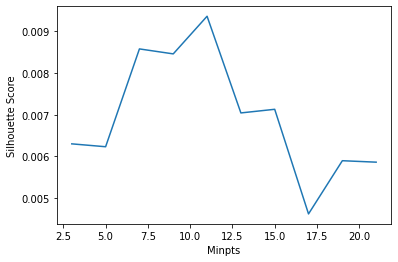

In [ ]:
plt.plot(mp, scores)
plt.ylabel('Silhouette Score')
plt.xlabel('Minpts')
plt.show()

In [ ]:
n_preds = assignFinalClusters(clus_cos, preds)
print(len(n_preds))
print(len(preds))

8580
8580


In [ ]:
with open('submission.dat', 'w') as f:
  for l in n_preds:
    f.write(str(l))
    f.write('\n')
  f.close()